In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls  
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from statsmodels.api import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc
import geopandas as gpd
from shapely.geometry import Point, Polygon

import warnings
warnings.filterwarnings('ignore')
# Gaussian family initialization
family = Gaussian()
np.set_printoptions(precision=3, suppress=True)

#### DGP

- Create census tracts (polygon) and points with the same grid extents i.e 0-100

In [2]:
# Function to create tract polygons over the area
def create_tracts(xmin, xmax, ymin, ymax, x_step, y_step):
    polys = []
    ids = []
    id_counter = 0
    for x0 in np.arange(xmin, xmax, x_step):
        for y0 in np.arange(ymin, ymax, y_step):
            x1 = x0 + x_step
            y1 = y0 + y_step
            poly = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
            polys.append(poly)
            ids.append(id_counter)
            id_counter += 1
    gdf = gpd.GeoDataFrame({'tract_id': ids, 'geometry': polys})
    return gdf

# Define grid parameters and create tracts
xmin, xmax = 0, 100
ymin, ymax = 0, 100

- Adjust the step size of the grid to increase or decrease the size of the tracts, so it has more or less points in it.

- The Census tracts are S1 (target supports). I also simulate S2 points and corresponding locations, with a mean of 50 and standard deviation of 30. 

In [3]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 10, 5  # Creates a 10x5 grid, resulting in 200 tracts
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2
def simulate_S2(num_points):
    np.random.seed(26)
    locations = np.random.rand(num_points, 2) * 100
    s2 = np.random.normal(50, 30, num_points)
    return s2, locations

S2, loc2 = simulate_S2(350)

#### Plot tracts and points

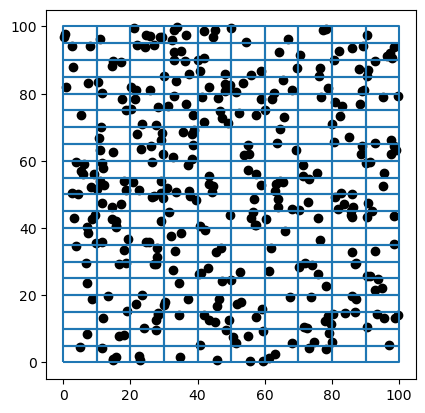

In [4]:
tracts_gdf.boundary.plot()
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

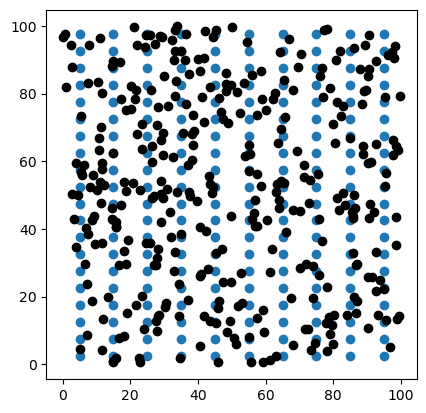

In [5]:
# tracts_gdf.boundary.plot()
tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

In [6]:
len(tracts_gdf)

200

#### Create different beta surfaces and base DGP

 --> S1 denotes census tracts <br />
 --> S2 denotes points<br />
 --> loc1 denotes centroids of the census tracts<br />
 --> loc2 denotes the locations of the S2 points<br />

In [7]:
S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2

In [8]:
def create_beta_surface(locations, heterogeneity='low'):
    """
    Create beta surface with low or high spatial heterogeneity. defaults to low if none is specified.  
    """
    x, y = locations[:, 0], locations[:, 1]
    if heterogeneity == 'low':
        B = x / 10 + y / 10
    elif heterogeneity == 'high':
        B = np.sin(x/10) * np.cos(y/10) + (x-50)**2/100 + (y-50)**2/100
    return B
    surface = 1 + 1/324 * (36*(6*x_locations_norm-2)**2) * (36*(6*y_locations_norm-2)**2)
    
    return surface

def uniform(locations):
    """
    Create constant surface with uniform/constant heterogeneity. 
    """
    surface = np.full(len(locations), 5)
    
    return surface


# B = create_beta_surface(loc1, heterogeneity='high')

B = uniform(loc1)


# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=10).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])
    

y = B * smoothed_S2_to_S1

 ### "I decided to use a constant beta surface (5) in this experiment as indicated in the uniform() function above. This is so I could see and determine how well the model recovers the beta parameters. All the estimated betas from local-gass and GWR should be very close to 5. The closer the better. And because it is a constant, the bandwidth should be large and closer to global. There goes my hypothesis"

#### Helper function

In [9]:
def calculate_aicc_rss(n, RSS, tr_S):
    """GWR-style AICc calculation using RSS and trace of the hat matrix (tr_S)."""
    # aicc = (n * np.log((RSS)/(n-tr_S))) + (n * np.log(2*np.pi)) + (n*((n+tr_S)/(n-2-tr_S)))
    term1 = 2 * n * np.log(RSS / n)
    term2 = n * np.log(2 * np.pi)
    term3 = n * ((n + tr_S) / (n - 2 - tr_S))
    
    aicc = term1 + term2 + term3
    return aicc
    
def calculate_aicc(n, log_likelihood, tr_S):
    """GWR-style AICc calculation using log-likelihood and trace of the hat matrix (tr_S)."""
    aic = -2 * log_likelihood + 2 * (tr_S + 1)
    aicc = aic + (2 * tr_S * (tr_S + 1)) / (n - tr_S - 1)
    return aicc

def log_likelihood_gaussian(residuals, n):
    """Calculate log-likelihood for Gaussian model."""
    sigma2 = np.sum(residuals**2) / n
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    return log_likelihood
    

def plot_true_and_recovered(true, recovered, coord):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(coord[:,0], coord[:, 1], c=true, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('True B Values')
    plt.colorbar(label='Beta Value')
    plt.title('True B Values')
    
    plt.subplot(1, 2, 2)
    plt.scatter(coord[:,0], coord[:, 1], c=recovered, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('recovered B Values')
    plt.colorbar(label='Beta Value')
    plt.title('recovered B Values')
    
    plt.tight_layout()
    plt.show()
    

In [10]:
def perform_local_regression(n_neighbor_est, loc1, loc2, S2, y):
    """
    Function that implements change of support into a GWR-like local model
    """
    recovered_betas = np.zeros(len(S1))
    residuals = np.zeros(len(S1))
    N = len(S1)
    
    resid_SS = []
    R = np.zeros((N, N))
    S = np.zeros((N, N))

    for i in range(len(S1)):
        # Find neighbors in S2 for current S1_i for smoothing
        nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])

        
        local_X = []
        weights_X = []
        
        # Smooth S2 onto S1 within the local regression function
        for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
            dist_j_to_i = distances_S1_to_S2[0][j]
            weight = np.exp(-0.5 * (dist_j_to_i / 14)**2)
            local_X.append(S2[neighbor_index_S2])
            weights_X.append(weight)

        local_X = np.array(local_X)
        weights_X = np.array(weights_X)
        weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)

        # Local regression using weighted S2 data at S1_i
        nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)
        distances, indices = nbrs_S1.kneighbors([loc1[i]])

        y_neighbors = y[indices[0]].reshape(-1, 1)
        X_neighbors = weighted_X_i * np.ones(len(indices[0])).reshape(-1, 1)

        weights_y = np.exp(-0.5 * (distances[0] / 14)**2).reshape(-1, 1)

        rslt = iwls(y_neighbors, X_neighbors, family, None, None, None, 1.0e-5, 40, wi=weights_y)

        recovered_betas[i] = rslt[0]
    
    ri = np.dot(X_neighbors, rslt[5])

    S[i, indices[0]] = ri[0] * rslt[4].flatten()
        
    y_pred_i = np.dot(X_neighbors[0], rslt[0])
    
    residuals[i] = y[i] - y_pred_i
    
    RSS = np.sum(residuals**2)
    resid_SS.append(RSS)
    
    # Calculate trace of S
    tr_S = np.trace(S)
    

    log_likelihood = log_likelihood_gaussian(residuals, len(S1)) # not used
    aicc_ll = calculate_aicc(len(S1), log_likelihood, tr_S) # not used
    
    aicc = calculate_aicc_rss(len(S1), RSS, tr_S) # both RSS & LL gives the same/near similar result
                                                  # But I prefer to use the RSS calculation because its more GWR-centric

    return recovered_betas, aicc_ll, tr_S

In [11]:
# Define range for number of neighbors
neighbors_values = list(range(10, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 194
Best AICc: 859.72


In [12]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

194

In [13]:
list(zip(aicc_values, neighbors_values))

[(923.086780966292, 10),
 (917.4291542627005, 12),
 (886.7960739328972, 14),
 (876.332221046891, 16),
 (877.2191382542159, 18),
 (871.8643416474176, 20),
 (868.291723998532, 22),
 (871.278199903002, 24),
 (866.9996401904136, 26),
 (864.5975822639804, 28),
 (864.2294182817171, 30),
 (863.9604805779716, 32),
 (864.1069489047059, 34),
 (863.3049198604242, 36),
 (862.3804138923247, 38),
 (861.3946391865496, 40),
 (860.9223191356613, 42),
 (860.5936104848737, 44),
 (860.3783697511011, 46),
 (860.3627989286078, 48),
 (860.1248444454067, 50),
 (860.0415154494171, 52),
 (859.9549001368301, 54),
 (859.8549299316356, 56),
 (859.8443149514707, 58),
 (859.8222294170529, 60),
 (859.7869137775904, 62),
 (859.7690676859152, 64),
 (859.7602813106088, 66),
 (859.7409452562295, 68),
 (859.7420980053862, 70),
 (859.7329868610857, 72),
 (859.7298204892131, 74),
 (859.7273784461239, 76),
 (859.7241124072896, 78),
 (859.7224507350043, 80),
 (859.7225349857807, 82),
 (859.7230766718403, 84),
 (859.7221351598

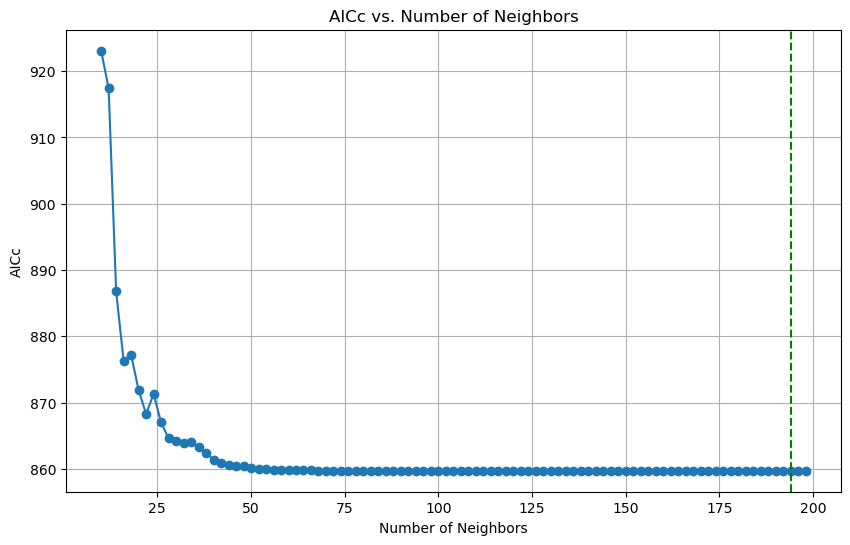

In [14]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

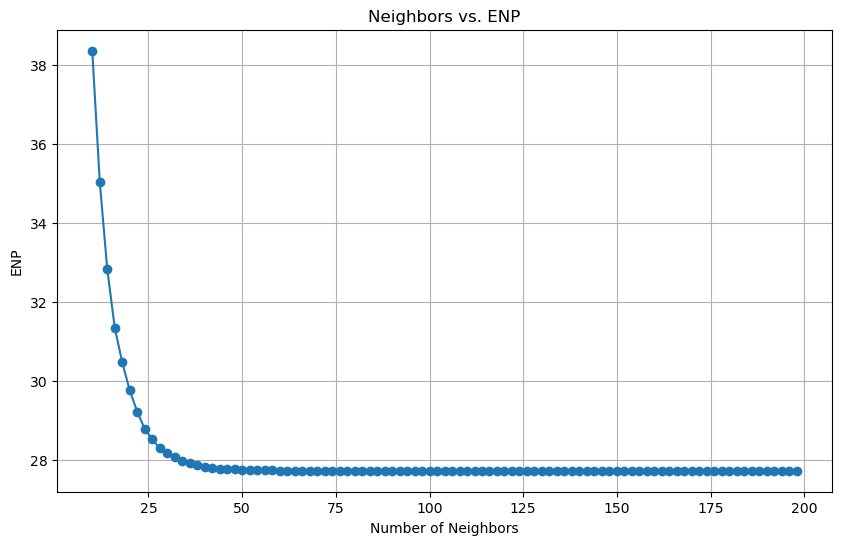

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, enp_values, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('ENP')
plt.title('Neighbors vs. ENP')
plt.grid(True)
plt.show()

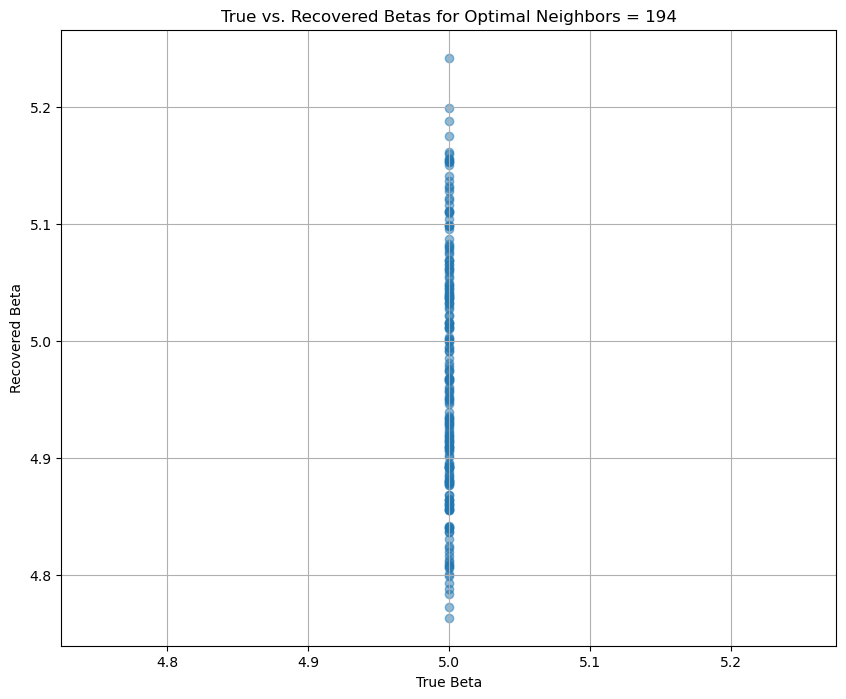

In [16]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors}')
plt.grid(True)
plt.show()

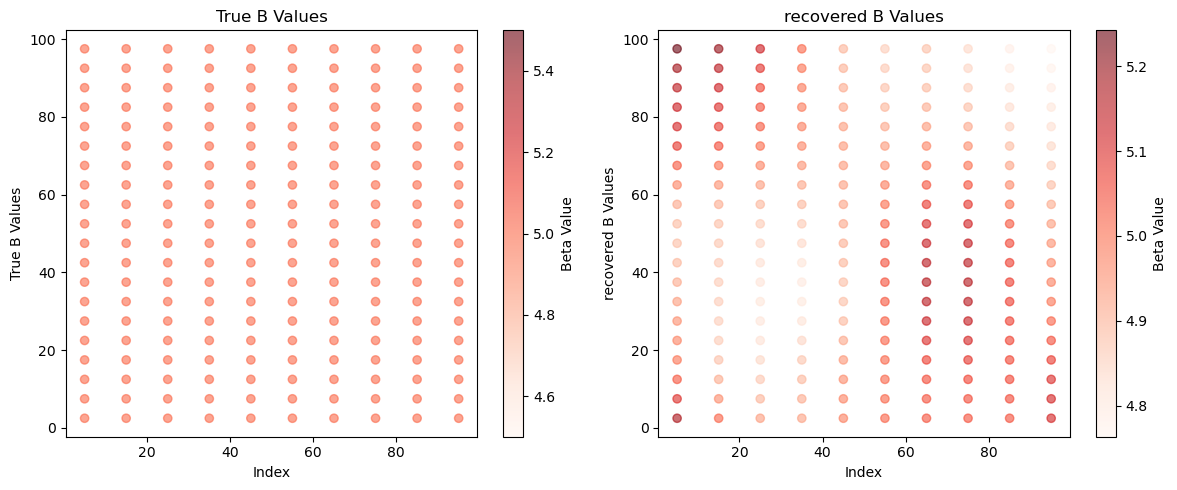

In [17]:
plot_true_and_recovered(B, recovered_betas_best, loc1)

In [18]:
B

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5])

In [19]:
recovered_betas_best.round(1)

array([5.2, 5.1, 5. , 5. , 5. , 5. , 4.9, 4.9, 4.9, 4.9, 4.9, 4.9, 5. ,
       5. , 5.1, 5.1, 5.1, 5.2, 5.2, 5.2, 5. , 5. , 4.9, 4.9, 4.9, 4.9,
       4.9, 4.9, 4.9, 4.9, 4.9, 4.9, 4.9, 5. , 5. , 5.1, 5.1, 5.1, 5.2,
       5.2, 4.9, 4.9, 4.9, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.9, 4.9,
       4.9, 5. , 5. , 5. , 5. , 5.1, 5.1, 5.1, 4.9, 4.9, 4.9, 4.9, 4.8,
       4.8, 4.8, 4.8, 4.8, 4.8, 4.9, 4.9, 4.9, 4.9, 5. , 5. , 5. , 5. ,
       5. , 5. , 5. , 5. , 5. , 4.9, 4.9, 4.9, 4.9, 4.9, 4.9, 4.9, 4.9,
       4.9, 4.9, 4.9, 4.9, 4.9, 4.9, 4.9, 4.9, 4.9, 5. , 5. , 5. , 5. ,
       5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 4.9, 4.9, 4.9,
       4.9, 4.9, 4.9, 5. , 5. , 5. , 5.1, 5.1, 5.1, 5.2, 5.2, 5.2, 5.1,
       5.1, 5.1, 5. , 5. , 5. , 4.9, 4.9, 4.9, 4.9, 4.9, 5. , 5. , 5.1,
       5.1, 5.1, 5.1, 5.2, 5.2, 5.2, 5.1, 5.1, 5.1, 5. , 5. , 5. , 4.9,
       4.9, 4.9, 4.8, 4.8, 5. , 5. , 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1,
       5.1, 5. , 5. , 5. , 4.9, 4.9, 4.9, 4.8, 4.8, 4.8, 4.8, 5.

### Aggregating points into census tracts for GWR

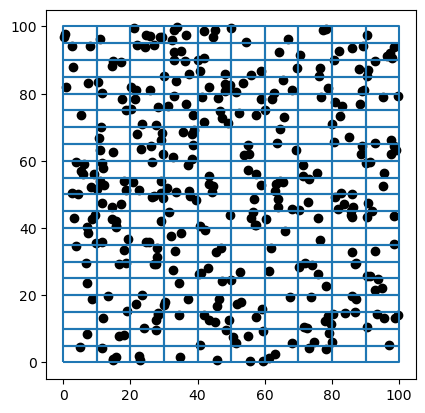

In [20]:
tracts_gdf.boundary.plot()
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

In [21]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))

In [22]:
df_S2.head()

,S2,geometry
0,74.801062,POINT (30.79350 51.93915)
1,58.675593,POINT (76.82977 78.92207)
2,108.023797,POINT (87.05621 18.79214)
3,45.694178,POINT (26.95052 49.61921)
4,83.671598,POINT (73.91217 19.49520)


<Axes: >

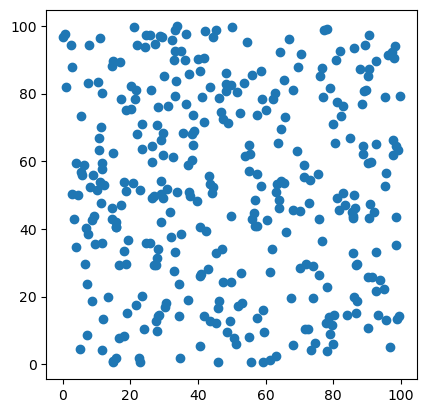

In [23]:
df_S2.plot()

#### Spatial Join and mean-aggregation

In [24]:
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')

In [25]:
joined.head()

,S2,geometry,index_right,tract_id
0,74.801062,POINT (30.79350 51.93915),70,70
33,61.987762,POINT (33.68172 50.83079),70,70
142,37.486025,POINT (37.44037 50.99988),70,70
1,58.675593,POINT (76.82977 78.92207),155,155
2,108.023797,POINT (87.05621 18.79214),163,163


<Axes: >

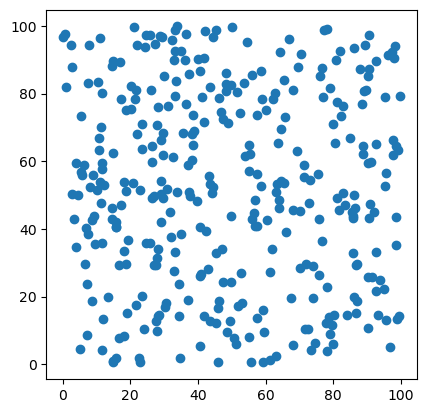

In [26]:
joined.plot()

In [27]:
sX = joined.groupby('tract_id').agg({'S2': ['mean']})#.reset_index()

In [28]:
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

In [29]:
# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')

In [30]:
sX1.head()

,tract_id,geometry,S2_mean
0,0,"POLYGON ((0.00000 0.00000, 10.00000 0.00000, 1...",14.719543
1,1,"POLYGON ((0.00000 5.00000, 10.00000 5.00000, 1...",70.528038
2,2,"POLYGON ((0.00000 10.00000, 10.00000 10.00000,...",NaN
3,3,"POLYGON ((0.00000 15.00000, 10.00000 15.00000,...",91.134917
4,4,"POLYGON ((0.00000 20.00000, 10.00000 20.00000,...",15.828319


In [31]:
sX1.isna().sum()

tract_id     0
geometry     0
S2_mean     31
dtype: int64

In [32]:
sX1.fillna({'S2_mean': 0.001}, inplace=True)

In [33]:
sX1.isna().sum()

tract_id    0
geometry    0
S2_mean     0
dtype: int64

In [34]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])

In [35]:
gwr_X.shape, gwr_y.shape

((200, 1), (200, 1))

#### Calibrate GWR

In [36]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [37]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [38]:
min(dict_aicc, key=dict_aicc.get)

198

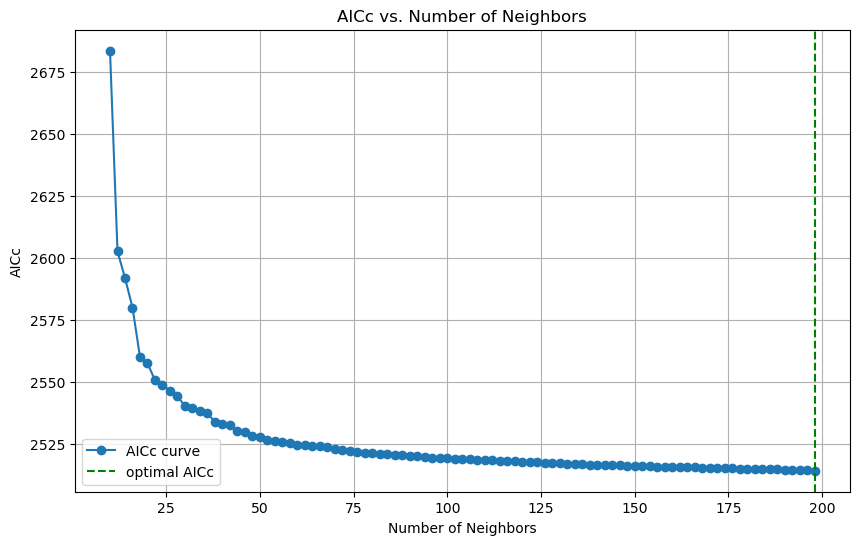

In [39]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

In [40]:
params[0].shape

(200, 1)

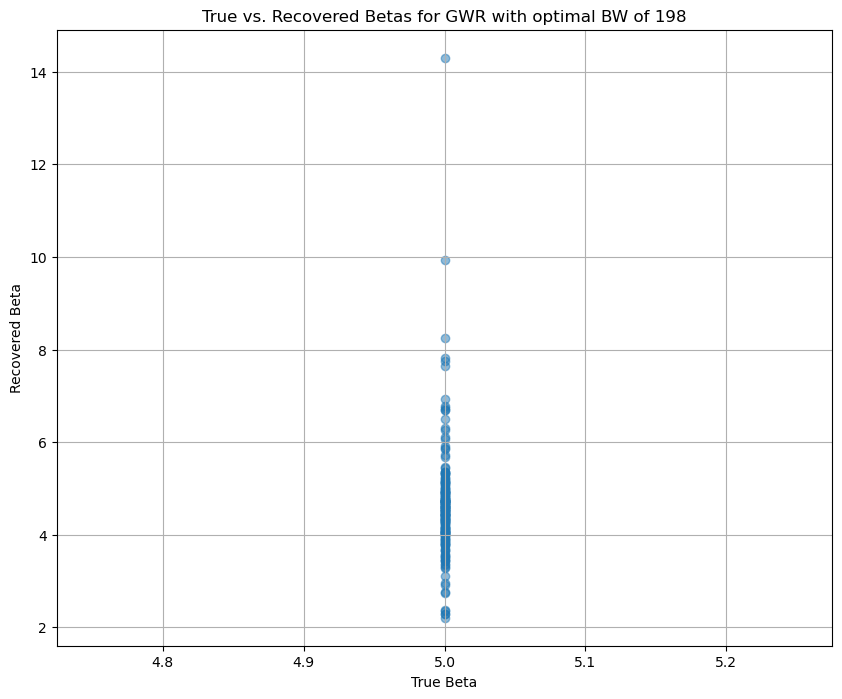

In [41]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}")
plt.grid(True)
plt.show()

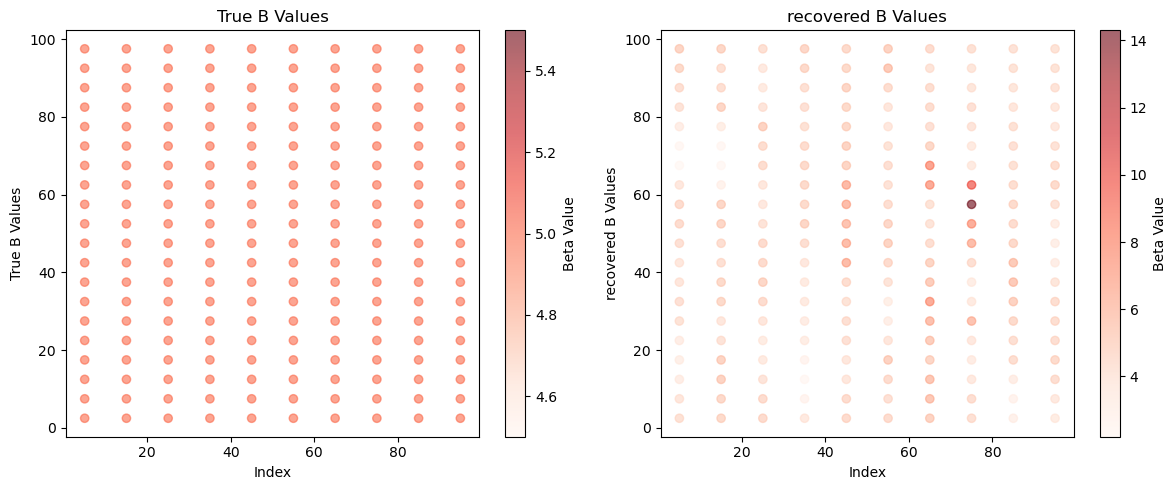

In [42]:
plot_true_and_recovered(B, params[0], loc1)

In [43]:
B

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5])

In [44]:
params[0].round(1).flatten()

array([ 4.4,  4.1,  3.4,  3.3,  3.5,  4.3,  4.5,  4.1,  4. ,  4.4,  4.7,
        4.7,  4. ,  2.2,  2.4,  3.5,  4.3,  4.6,  4.9,  5.2,  4.9,  5. ,
        5.3,  5.3,  4.2,  4. ,  4.9,  4.9,  4.5,  4.6,  5.2,  5.1,  3. ,
        2.3,  2.4,  3.4,  5.2,  4.5,  4.5,  5.1,  4.8,  4.7,  4.2,  3.8,
        3.7,  4.1,  4.7,  5.1,  4.8,  4.8,  4.3,  3.9,  4. ,  4.7,  4.7,
        5.4,  4.2,  3.8,  3.9,  4.5,  3.9,  2.7,  2.3,  2.8,  3.5,  3.7,
        3.8,  3.8,  4. ,  4.6,  5.1,  4.8,  4.9,  4.9,  4.7,  4.4,  4.5,
        4.5,  5. ,  5.1,  4.8,  4.7,  4. ,  4. ,  4.5,  4.6,  4.3,  4.7,
        6.8,  6.7,  6.3,  6.7,  6.9,  5.2,  5.3,  5. ,  4.9,  5.1,  4.9,
        4.9,  4.7,  4.5,  4.7,  5.4,  4.1,  3.3,  3.3,  4.2,  4.8,  5.3,
        5.1,  4.6,  4.4,  4.5,  4.3,  4. ,  4.1,  4.7,  5.9,  5.4,  5.3,
        6.1,  6.1,  5.1,  5.7,  6.5,  7.7,  5.7,  5.2,  4.6,  4.2,  4.3,
        7.8,  8.3,  5. ,  4.4,  4.7,  4.6,  4.2,  4.7,  4.5,  4.6,  3.9,
        3.6,  3.9,  6.3,  3.8,  3.6,  4.5,  6.7,  7

##### They both recover the true scale but GWR has more errors in recovering the true betas..

### Next experiment will be increasing the size of the tracts to 10x8 grids (130 tracts) and have the results compared

##### Here, i have increased the tracts to 10x8. It was previously 10x5. 

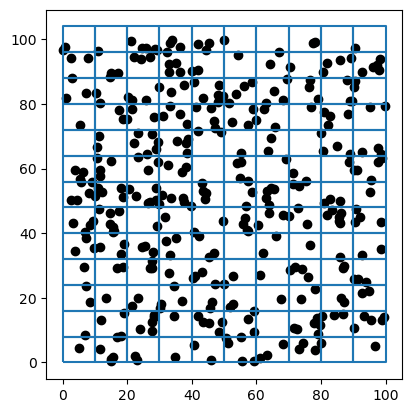

In [45]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 10, 8  # Creates a 10x8 grid, resulting in 130 tracts
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2
def simulate_S2(num_points):
    np.random.seed(26)
    locations = np.random.rand(num_points, 2) * 100
    s2 = np.random.normal(50, 30, num_points)
    return s2, locations

S2, loc2 = simulate_S2(350)

tracts_gdf.boundary.plot()
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = uniform(loc1)


# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=10).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [46]:
# Define range for number of neighbors
neighbors_values = list(range(10, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 124
Best AICc: 702.69


In [47]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

124

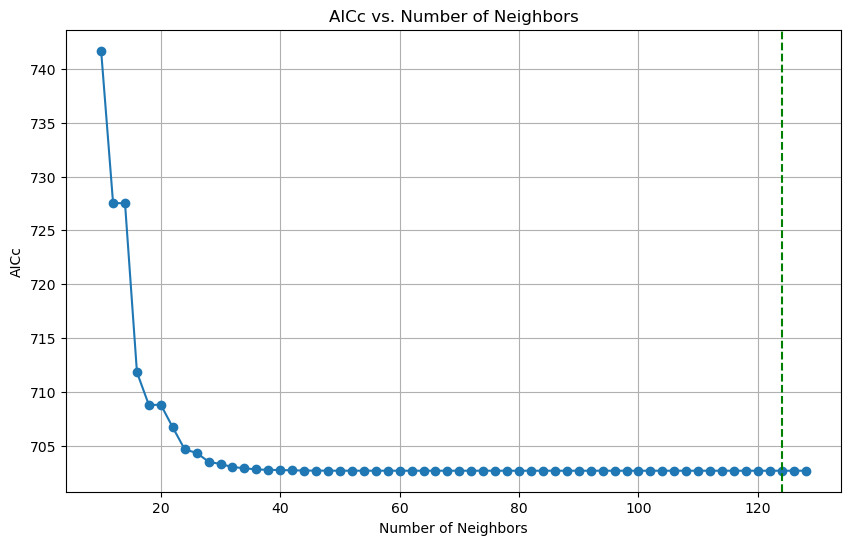

In [48]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

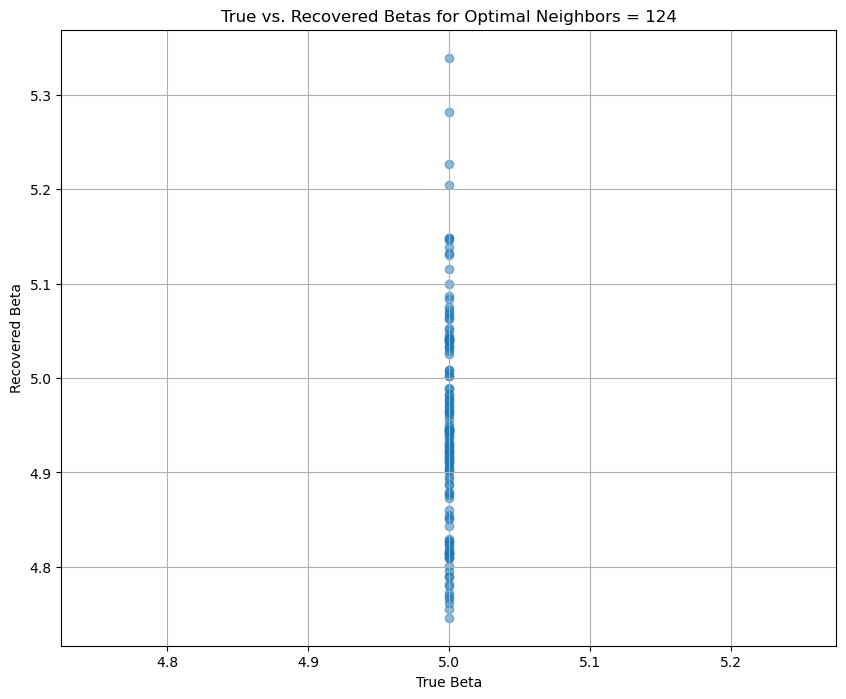

In [49]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors}')
plt.grid(True)
plt.show()

### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [50]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.001}, inplace=True)

In [51]:
sX1.head()

,tract_id,geometry,S2_mean
0,0,"POLYGON ((0.000 0.000, 10.000 0.000, 10.000 8....",14.719543
1,1,"POLYGON ((0.000 8.000, 10.000 8.000, 10.000 16...",70.528038
2,2,"POLYGON ((0.000 16.000, 10.000 16.000, 10.000 ...",53.481618
3,3,"POLYGON ((0.000 24.000, 10.000 24.000, 10.000 ...",20.775666
4,4,"POLYGON ((0.000 32.000, 10.000 32.000, 10.000 ...",52.066924
...,...,...,...
125,125,"POLYGON ((90.000 64.000, 100.000 64.000, 100.0...",41.535887
126,126,"POLYGON ((90.000 72.000, 100.000 72.000, 100.0...",60.670023
127,127,"POLYGON ((90.000 80.000, 100.000 80.000, 100.0...",23.200391
128,128,"POLYGON ((90.000 88.000, 100.000 88.000, 100.0...",50.157959


##### Specify GWR parameters

In [52]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((130, 1), (130, 1))

In [53]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

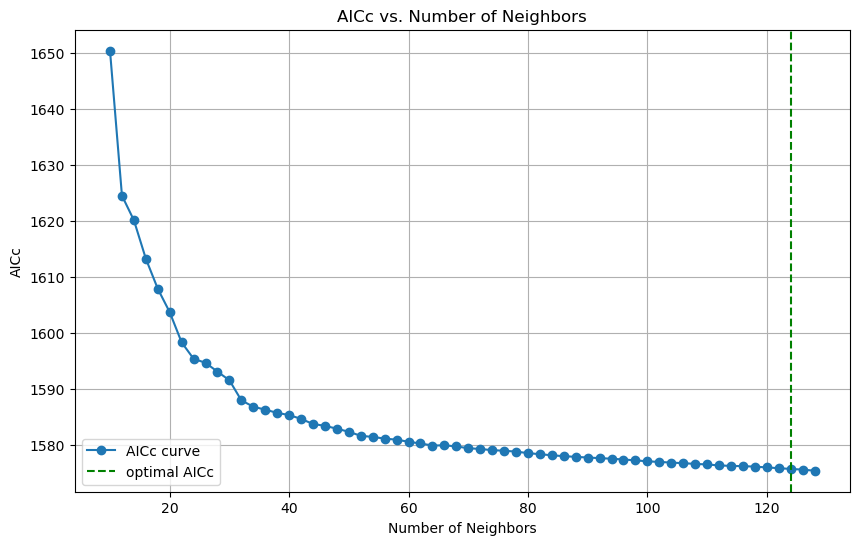

In [54]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

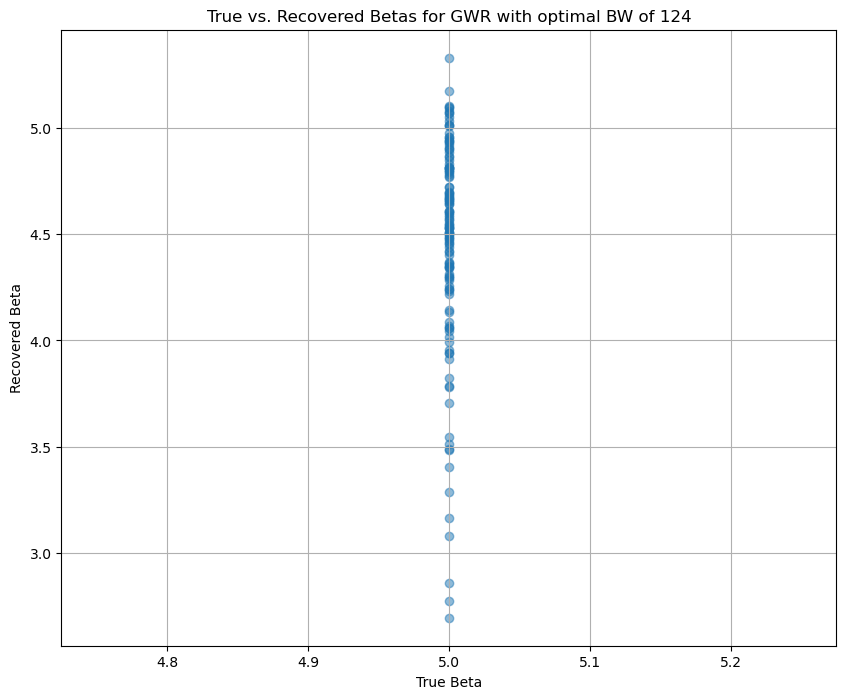

In [55]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}")
plt.grid(True)
plt.show()

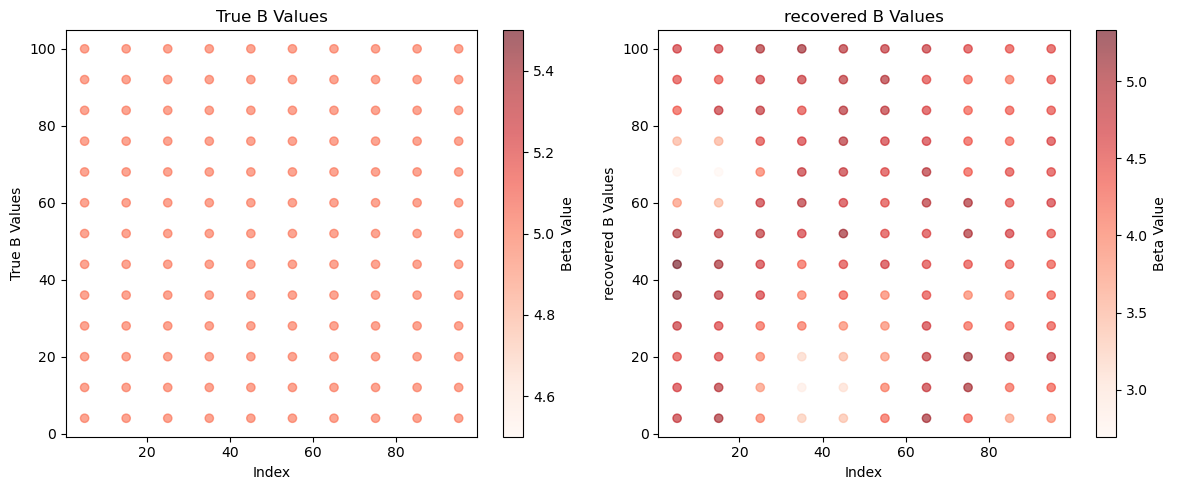

In [56]:
plot_true_and_recovered(B, params[0], loc1)

GWR still has more variation in recovering the true betas

### Further increasing the size of the tracts to 10x10 grids (100 tracts) and have the results compared

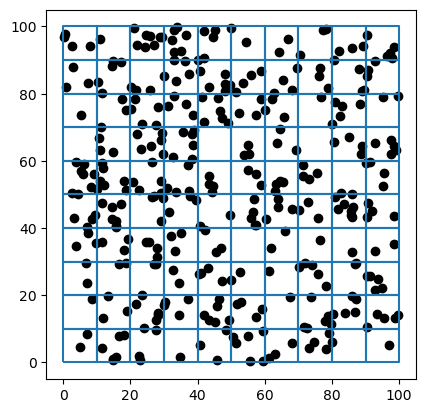

In [57]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 10, 10  # Creates a 10x8 grid, resulting in 130 tracts
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2
def simulate_S2(num_points):
    np.random.seed(26)
    locations = np.random.rand(num_points, 2) * 100
    s2 = np.random.normal(50, 30, num_points)
    return s2, locations

S2, loc2 = simulate_S2(350)

tracts_gdf.boundary.plot()
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = uniform(loc1)

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=10).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [58]:
len(S1), len(y), len(S2)

(100, 100, 350)

In [59]:
# Define range for number of neighbors
neighbors_values = list(range(10, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 96
Best AICc: 516.88


In [60]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

96

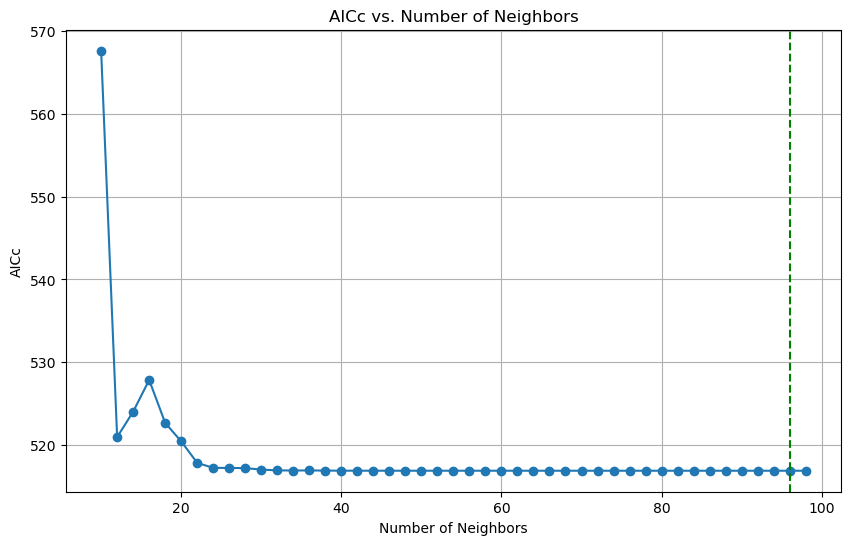

In [61]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

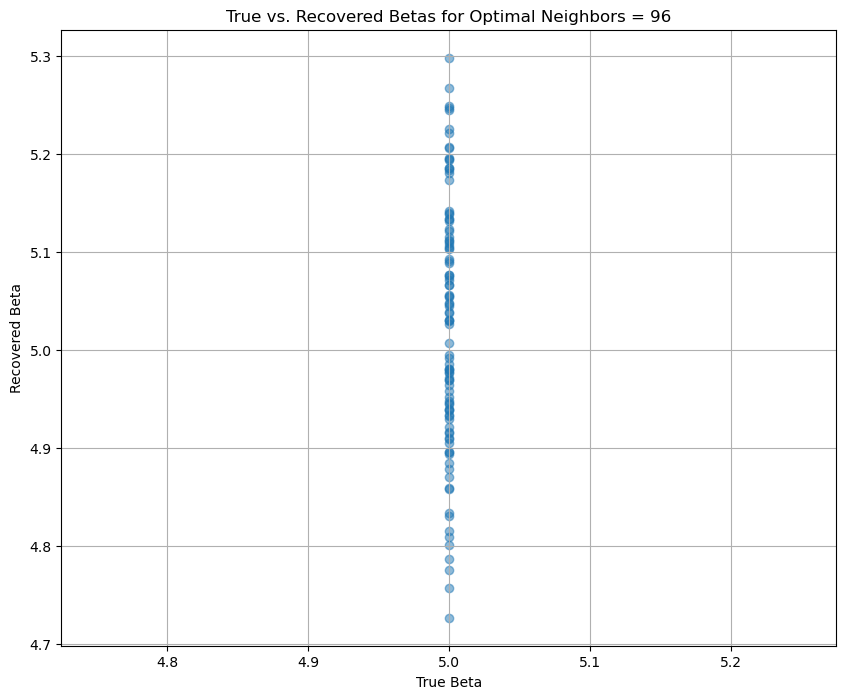

In [62]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors}')
plt.grid(True)
plt.show()

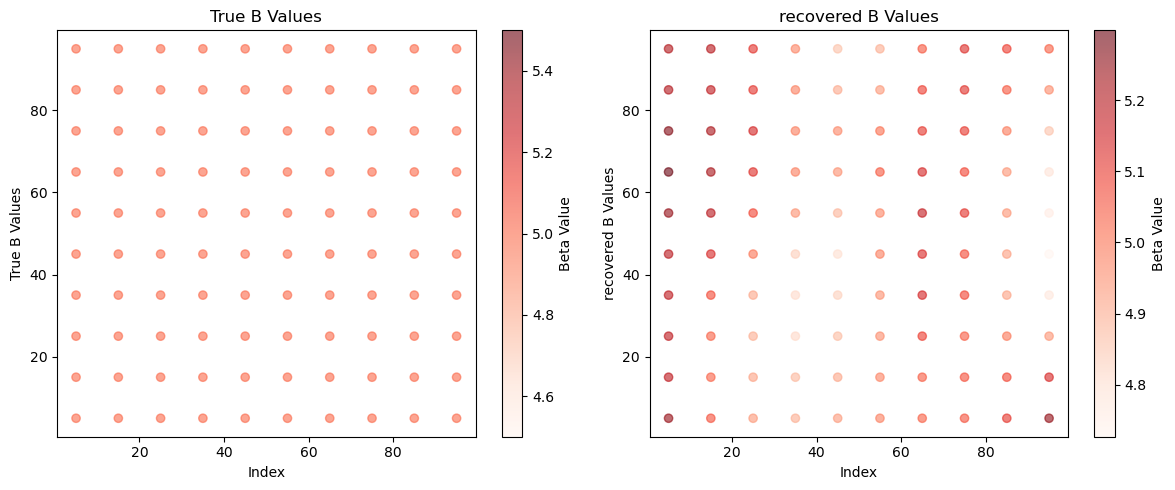

In [63]:
plot_true_and_recovered(B, recovered_betas_best, loc1)

### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [64]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.001}, inplace=True)

In [65]:
sX1.head()

,tract_id,geometry,S2_mean
0,0,"POLYGON ((0.00000 0.00000, 10.00000 0.00000, 1...",42.623790
1,1,"POLYGON ((0.00000 10.00000, 10.00000 10.00000,...",91.134917
2,2,"POLYGON ((0.00000 20.00000, 10.00000 20.00000,...",18.301993
3,3,"POLYGON ((0.00000 30.00000, 10.00000 30.00000,...",52.066924
4,4,"POLYGON ((0.00000 40.00000, 10.00000 40.00000,...",39.235652


##### Specify GWR parameters

In [66]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((100, 1), (100, 1))

In [67]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

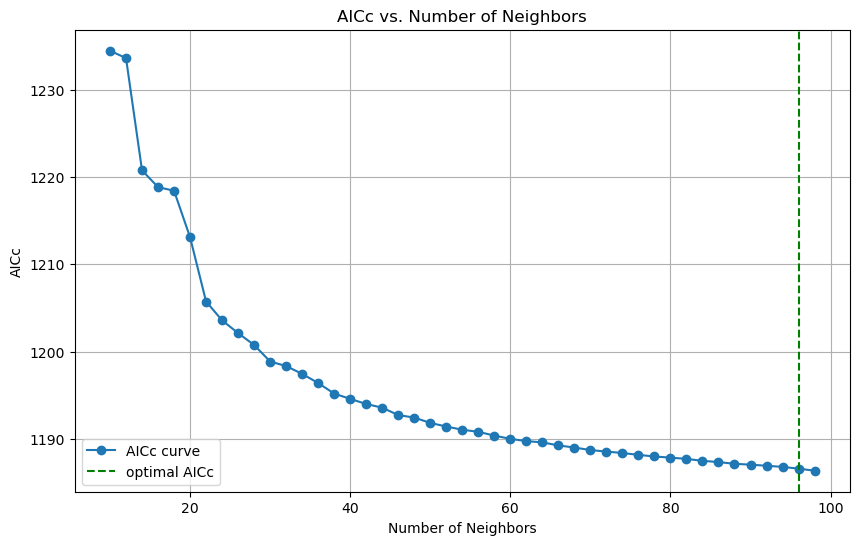

In [68]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

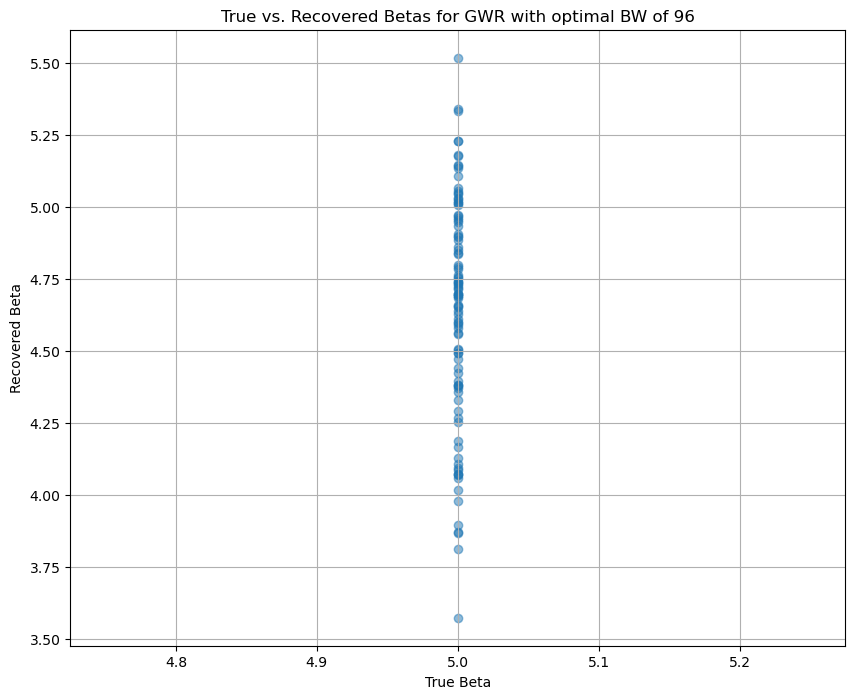

In [69]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}")
plt.grid(True)
plt.show()

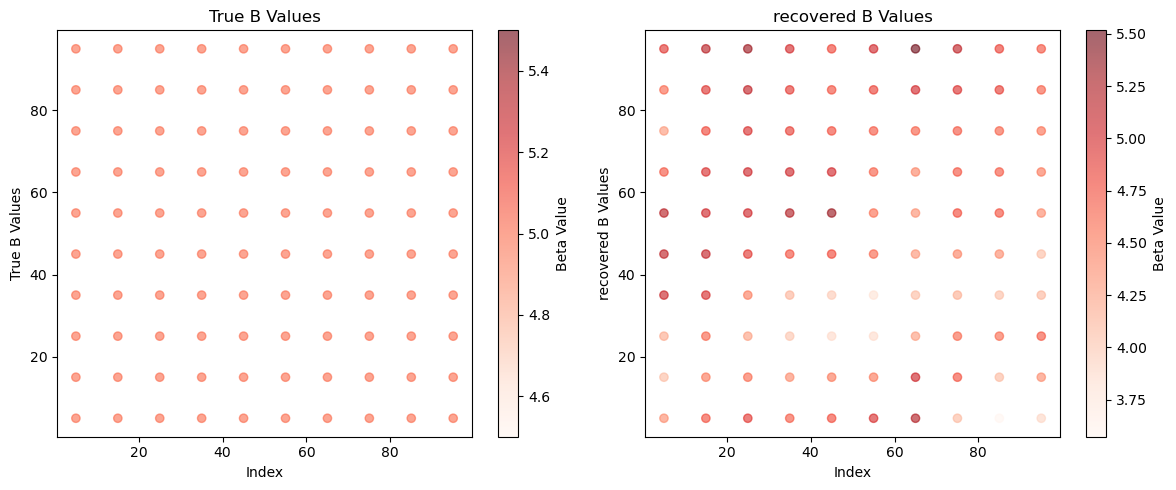

In [70]:
plot_true_and_recovered(B, params[0], loc1)